<a href="https://colab.research.google.com/github/DanieleCecca/ball-action-spotting-app/blob/main/Notebooks/Ball_Action_Spotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ball Action Spotting

*Daniele Cecca*

*Matr. 914358*

*MSc Artificial Intelligence for Science and Technology*

*Email: d.cecca@campus.unimib.*

This project focuses on the development and implementation of **classification system for ball events in a football match**, also called ball action spotting.
It utilizes the **SoccerNet dataset** and draws inspiration from previously proposed solutions.


## Utilities

I install the library and I define the imports

In [1]:
!pip install SoccerNet
!pip install skimpy
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━

In [65]:
from SoccerNet.Downloader import SoccerNetDownloader

from torch.utils.data import Dataset
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import v2

import torch
import torch.nn as nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimpy import skim
from sklearn.preprocessing import LabelEncoder

from IPython.display import HTML


import os
from shutil import copyfile
import shutil
import random


import cv2
from PIL import Image
from torchvision.transforms import v2
from torchvision.ops import sigmoid_focal_loss
import json

import wandb
import seaborn as sns

# Metrics for evaluating the performance of machine learning models
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


I set the device where the training will be performed

In [3]:
# Check if GPU (Graphics Processing Unit) is available for training
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Define the device to use for training based on GPU availability
device = torch.device("cuda:0" if train_on_gpu else "cpu")

# Print the chosen device for training
print(device)

CUDA is available!  Training on GPU ...
cuda:0


## Utility functions

I define some function useful to manage the data and some function useful to load some metrics on wandb dashboard

In [4]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
def delete_folder(folder_path):
    if os.path.exists(folder_path):
        try:
            shutil.rmtree(folder_path)
            print(f"Folder '{folder_path}' has been deleted successfully.")
        except Exception as e:
            print(f"Error: {e}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

In [6]:
def remove_720p_videos(folder_data):
  leagues_files=os.listdir(folder_data)
  for league  in leagues_files:
      league_path=os.path.join(folder_data,league)
      years=os.listdir(league_path)
      for year in years:
        year_path=os.path.join(league_path,year)
        games=os.listdir(year_path)
        for game in games:
          files=os.listdir(os.path.join(year_path,game))
          for  video in files:
            if '720p.mp4' in video:
              os.remove(os.path.join(year_path,game,'720p.mp4'))


In [7]:
def load_json_annotations(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data['annotations']

In [8]:
def convert_game_time_to_seconds(game_time):
    period, time_str = game_time.split('-')
    period=period.strip()
    time_str=time_str.strip()
    minutes, seconds = map(int, time_str.split(':'))
    return (period,minutes * 60 + seconds)

In [9]:
def train_log(loss, example_ct, epoch):
    loss = float(loss)

    # add metrics to wandb
    wandb.log({"epoch": epoch, "train/loss": loss}, step=example_ct)


In [10]:
def test_log(loss, accuracy, example_ct, epoch):
    loss = float(loss)
    accuracy = float(accuracy)

    # add metrics to wandb
    wandb.log({"epoch": epoch, "validation/loss": loss, "validation/accuracy": accuracy}, step=example_ct)


## Dataset

### Load Dataset

The dataset is composed of **7 videos** of English Football League games, and to each video a **JSON** with the timestamp and the label is associated.

In total we have have **12 different type of action**, some of them really similar one to each other:
1. **Pass**
2. **Drive**
3. **Header**
4. **High Pass**
5. **Out**
6. **Cross**
7. **Throw In**
8. **Shot**
9. **Ball Player Block**
10. **Player Successful Tackle**
11. **Free Kick**
12. **Goal**

I create a folder where the data will be moved and I download the zip files where the data for this task are stored.

In [11]:
DATA_PATH=os.path.join(os.getcwd(), "data")

In [12]:
create_dir(DATA_PATH)

In [13]:
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory=DATA_PATH)
mySoccerNetDownloader.downloadDataTask(task="spotting-ball-2024", split=["train", "valid", "test", "challenge"], password="s0cc3rn3t")

In [14]:
!unzip -q /content/data/spotting-ball-2024/train.zip -d train_set
!unzip -q /content/data/spotting-ball-2024/test.zip -d test_set
!unzip -q /content/data/spotting-ball-2024/valid.zip -d val_set
!unzip -q /content/data/spotting-ball-2024/challenge.zip -d challenge

In [ ]:
shutil.move("/content/train_set", "/content/data")
shutil.move("/content/test_set", "/content/data")
shutil.move("/content/val_set", "/content/data")
shutil.move("/content/challenge", "/content/data")

In [16]:
train_set_path=os.path.join(DATA_PATH,"train_set")
test_set_path=os.path.join(DATA_PATH,"test_set")
val_set_path=os.path.join(DATA_PATH,"val_set")

In [17]:
delete_folder('/content/SoccerNetv2-DevKit')
delete_folder('/content/data/spotting-ball-2024')

Folder '/content/SoccerNetv2-DevKit' does not exist.
Folder '/content/data/spotting-ball-2024' has been deleted successfully.


For computational limit I use only the video at 224p and I remove the video-match at 720p.
Both videos represent the same match.

In [18]:
remove_720p_videos(train_set_path)
remove_720p_videos(test_set_path)
remove_720p_videos(val_set_path)

### Create Dataframe

I am creating a dataframe where each sample represents a video segment containing an action and its corresponding label.

To start, I need to split the video matches.
Since defining precise temporal boundaries for actions is challenging because it's hard to pinpoint the exact start and end times, and knowing what occurs after the action can be beneficial, I extend the interval by one second beyond the defined action times in the JSON file.

I define a fuction to split the video-match into small videos.

In [19]:
def split_video_based_on_annotations(video_path, annotations, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open video file
    video = cv2.VideoCapture(video_path)
    fps = int(video.get(cv2.CAP_PROP_FPS))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    #name id video
    video_name=video_path.split('/')[-2] + '_' + video_path.split('/')[-1].split('.')[0]
    print(video_name)

    # Convert annotations to timestamps in seconds
    timestamps = [convert_game_time_to_seconds(a['gameTime']) for a in annotations]

    data=[]
    # Process video in segments(i take also the second after the annotation is indicated)
    for i in range(len(timestamps) - 1):
        start_time = timestamps[i][1]
        end_time = timestamps[i + 1][1] + 1

        clip_duration = end_time - start_time

        # Define codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        clip_filename = os.path.join(output_folder, f"{video_name}_clip_{i+1:04d}.mp4")
        out = cv2.VideoWriter(clip_filename, fourcc, fps, (width, height))

        # Check if the VideoWriter object was successfully created
        if not out.isOpened():
            print(f"Errore nella creazione del file video: {clip_filename}")
            continue
        #TO DO Create directly here the dataframe
        data.append({
            'clip_filename': clip_filename,
            'label': annotations[i]['label'],
            'clip_duration': clip_duration
        })

        # Set the video position to the start_time
        video.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)
        current_time = start_time

        while current_time < end_time:
            success, frame = video.read()
            if not success:
                break
            out.write(frame)
            current_time += 1 / fps

        out.release()

    video.release()
    return data

I define the function to create the dataframe for each dataset.This fuction calls the function

```
split_video_based_on_annotations(video_path, annotations, output_folder)
```



In [20]:
def create_dataframe(folder_data,output_folder):

  df=pd.DataFrame(columns=['clip_filename','label','clip_duration'])
  leagues_files=os.listdir(folder_data)
  for league  in leagues_files:
    league_path=os.path.join(folder_data,league)
    years=os.listdir(league_path)
    for year in years:
      year_path=os.path.join(league_path,year)
      games=os.listdir(year_path)
      for game in games:
        files=os.listdir(os.path.join(year_path,game))
        videos=[video for  video in files if video.endswith('.mp4')]
        jsons=[json for  json in files if json.endswith('.json')][0]

        for video in videos:
          video_path=os.path.join(year_path,game,video)
          jsons_path=os.path.join(year_path,game,jsons)
          sample=split_video_based_on_annotations(video_path,load_json_annotations(jsons_path),output_folder)
          df = pd.concat([df, pd.DataFrame(sample)], ignore_index=True)
    return df

I define the path where the small videos will be saved.Their names have the following pattern:

*2019-10-01 - Middlesbrough - Preston North End_224p_clip_0001.mp4*

*date - team1 - team 224p_clip#*

In [21]:
new_trainig_data=os.path.join(DATA_PATH,"new_trainig_data")
new_test_data=os.path.join(DATA_PATH,"new_test_data")
new_val_data=os.path.join(DATA_PATH,"new_val_data")

In [22]:
trainig_df=create_dataframe(train_set_path,new_trainig_data)

2019-10-01 - Brentford - Bristol City_224p
2019-10-01 - Hull City - Sheffield Wednesday_224p
2019-10-01 - Leeds United - West Bromwich_224p
2019-10-01 - Blackburn Rovers - Nottingham Forest_224p


In [23]:
test_df=create_dataframe(test_set_path,new_test_data)

2019-10-01 - Reading - Fulham_224p
2019-10-01 - Stoke City - Huddersfield Town_224p


In [24]:
val_df=create_dataframe(val_set_path,new_val_data)

2019-10-01 - Middlesbrough - Preston North End_224p


In [25]:
trainig_df.to_csv('trainig_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)

### Exploration of the data

Now that I have the dataframes of each data set, I observe some basic statistics and the frquency of each label, for each data set.

In [26]:
trainig_df=pd.DataFrame.from_dict(trainig_df)
test_df=pd.DataFrame.from_dict(test_df)
val_df=pd.DataFrame.from_dict(val_df)

In [27]:
trainig_df.head()


,clip_filename,label,clip_duration
0,/content/data/new_trainig_data/2019-10-01 - Br...,PASS,3
1,/content/data/new_trainig_data/2019-10-01 - Br...,DRIVE,2
2,/content/data/new_trainig_data/2019-10-01 - Br...,HIGH PASS,4
3,/content/data/new_trainig_data/2019-10-01 - Br...,HEADER,2
4,/content/data/new_trainig_data/2019-10-01 - Br...,DRIVE,5


In [28]:
test_df.head()

,clip_filename,label,clip_duration
0,/content/data/new_test_data/2019-10-01 - Readi...,PASS,2
1,/content/data/new_test_data/2019-10-01 - Readi...,DRIVE,2
2,/content/data/new_test_data/2019-10-01 - Readi...,PASS,2
3,/content/data/new_test_data/2019-10-01 - Readi...,DRIVE,2
4,/content/data/new_test_data/2019-10-01 - Readi...,PASS,2


In [29]:
val_df.head()

,clip_filename,label,clip_duration
0,/content/data/new_val_data/2019-10-01 - Middle...,PASS,1
1,/content/data/new_val_data/2019-10-01 - Middle...,DRIVE,2
2,/content/data/new_val_data/2019-10-01 - Middle...,PASS,3
3,/content/data/new_val_data/2019-10-01 - Middle...,DRIVE,4
4,/content/data/new_val_data/2019-10-01 - Middle...,HIGH PASS,7


The dataset is really unbalanced

label
PASS                        2678
DRIVE                       2296
HIGH PASS                    464
HEADER                       404
OUT                          331
THROW IN                     212
CROSS                        177
BALL PLAYER BLOCK            128
SHOT                         100
PLAYER SUCCESSFUL TACKLE      34
FREE KICK                     15
GOAL                           6
Name: count, dtype: int64


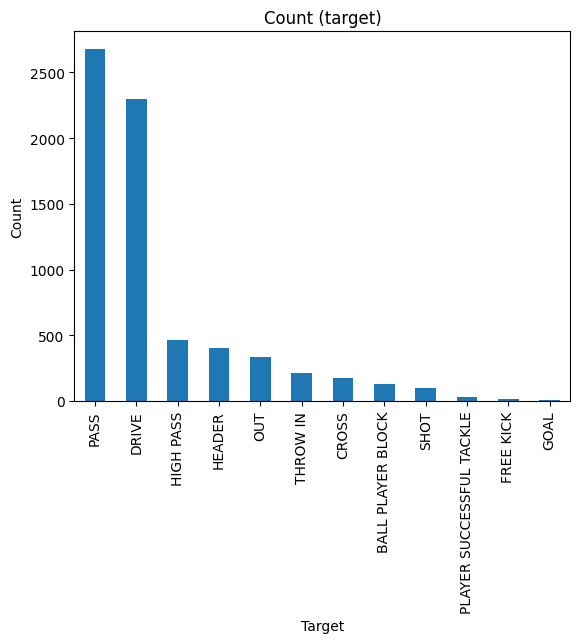

In [30]:
target_count = trainig_df['label'].value_counts()
print(target_count)

target_count = trainig_df['label'].value_counts()
target_count.plot(kind='bar', title='Count (target)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


label
PASS                        1721
DRIVE                       1448
HEADER                       182
HIGH PASS                    180
OUT                          145
THROW IN                      95
BALL PLAYER BLOCK             67
CROSS                         60
SHOT                          44
PLAYER SUCCESSFUL TACKLE      28
GOAL                           6
FREE KICK                      2
Name: count, dtype: int64


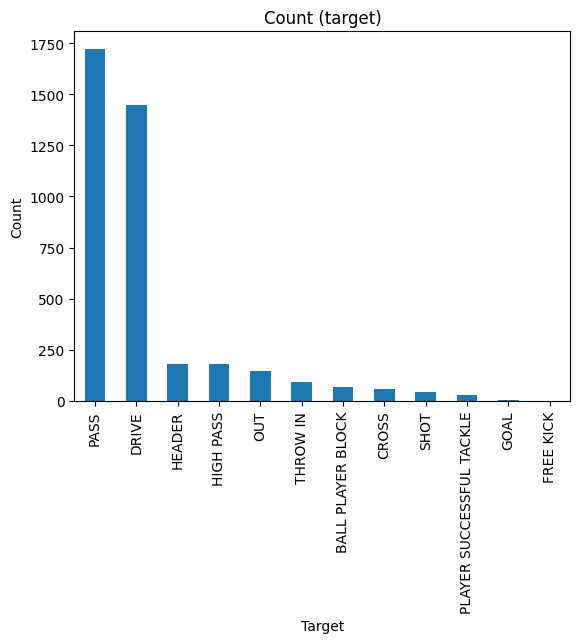

In [31]:
target_count = test_df['label'].value_counts()
print(target_count)

target_count = test_df['label'].value_counts()
target_count.plot(kind='bar', title='Count (target)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

label
PASS                        585
DRIVE                       554
HEADER                      127
HIGH PASS                   115
OUT                          74
THROW IN                     54
BALL PLAYER BLOCK            28
SHOT                         25
CROSS                        24
PLAYER SUCCESSFUL TACKLE     12
FREE KICK                     4
GOAL                          1
Name: count, dtype: int64


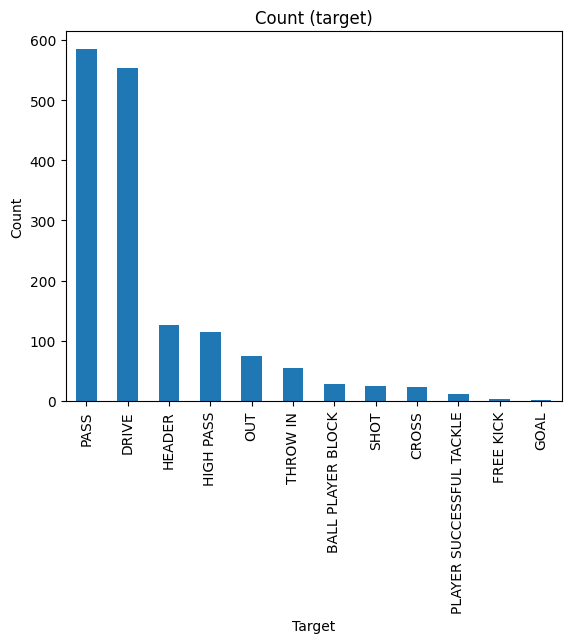

In [32]:
target_count = val_df['label'].value_counts()
print(target_count)

target_count = val_df['label'].value_counts()
target_count.plot(kind='bar', title='Count (target)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

I use the label encoding to encode the labels attribute as number

In [33]:
le = LabelEncoder()
le.fit(trainig_df['label'])
trainig_df['label'] = le.transform(trainig_df['label'])

le = LabelEncoder()
le.fit(test_df['label'])
test_df['label'] = le.transform(test_df['label'])

le = LabelEncoder()
le.fit(val_df['label'])
val_df['label'] = le.transform(val_df['label'])

By observing this data I can deduce that the mean duration of the clips is of 4sec.

In [34]:
skim(trainig_df)
skim(test_df)
skim(val_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 6845   │ │ int64       │ 2     │                                                          │
│ │ Number of columns │ 3      │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA   ┃ NA %    ┃ mean     ┃ sd       ┃ p0   ┃ p25   ┃ p50   ┃ p75  ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ label               │    0 │       0 │    5.408 │    3.014 │    0 │     2 │     6 │    8 │    11 │ ▁▇▁▂▇▁  │  │
│ │ clip_duration       │    0 │       0 │    4.366 │    7.357 │    1 │     2 │     3 │    4 │   149 │    ▇    │  │
│ └─────────────────────┴──────┴─────────┴──────────┴──────────┴──────┴───────┴───────┴──────┴───────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ clip_filename                │      0 │          0 │                         6.7 │                   46101 │  │
│ └──────────────────────────────┴────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3978   │ │ int64       │ 2     │                                                          │
│ │ Number of columns │ 3      │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA   ┃ NA %    ┃ mean     ┃ sd       ┃ p0   ┃ p25   ┃ p50   ┃ p75  ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ label               │    0 │       0 │    5.404 │    3.019 │    0 │     2 │     7 │    8 │    11 │ ▁▇▁▁▇▁  │  │
│ │ clip_duration       │    0 │       0 │        4 │     7.68 │    1 │     2 │     3 │    3 │   177 │    ▇    │  │
│ └─────────────────────┴──────┴─────────┴──────────┴──────────┴──────┴───────┴───────┴──────┴───────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ clip_filename                │      0 │          0 │                         5.9 │                   23576 │  │
│ └──────────────────────────────┴────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1603   │ │ int64       │ 2     │                                                          │
│ │ Number of columns │ 3      │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA   ┃ NA %    ┃ mean     ┃ sd       ┃ p0   ┃ p25   ┃ p50   ┃ p75  ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ label               │    0 │       0 │    5.379 │    2.987 │    0 │     2 │     6 │    8 │    11 │ ▁▇▂▃▇▁  │  │
│ │ clip_duration       │    0 │       0 │    4.662 │    8.153 │    1 │     2 │     3 │    4 │   104 │    ▇    │  │
│ └─────────────────────┴──────┴─────────┴──────────┴──────────┴──────┴───────┴───────┴──────┴───────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ clip_filename                │      0 │          0 │                           7 │                   11221 │  │
│ └──────────────────────────────┴────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

## Neural Network

### Class Dataset

I define the **ActionRecognitionDataset class**. This class is developed to manage the loading and video data in action recognition tasks.The key functionalities include loading video frames, stacking consecutive frames, and applying optional transformations.

The main idea is to take for each clip 15 frames, one every 12 frames(because the mean lenght is 4),and then divide this frames in stack of 3 frames.
So in the end we will have a vector of [1,5, 3, 224, 398] where [B,T ,C ,H ,W].

Thi will be useful to stack temporal information that will be processe by the network

In [35]:
class ActionRecognitionDataset(Dataset):
    def __init__(self, dataframe, num_frames=15, frames_per_stack=3, transform=None):
        """
        Args:
            video_paths (list of str): List of paths to video files or directories of frames.
            labels (list of int): List of labels corresponding to each video.
            num_frames (int): Total number of frames to consider from each video.
            frames_per_stack (int): Number of consecutive frames to stack as channels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.video_paths = dataframe['clip_filename']
        self.labels = dataframe['label']

        self.num_frames = num_frames
        self.frames_per_stack = frames_per_stack
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths.iloc[idx]
        label = self.labels.iloc[idx]


        # Load frames
        frames = self.load_frames(video_path)

        # Stack frames
        stacked_frames = self.stack_frames(frames)
        #stacked_frames = stacked_frames.unsqueeze(0)

        # Convert label to tensor
        label = torch.tensor(label).long()
        return stacked_frames, label

    def load_frames(self, video_path):
        """
        Load and return the required number of grayscale frames from a video file.
        """
        frames = []
        cap = cv2.VideoCapture(video_path)
        success, frame = cap.read()
        count = 0
        frame_taken=0

        #TO DO One thing that i can do is to duplicate the video with less number and take 15 frame casualy
        #Because the mean of the videos is 3. something I take the frame every 12frame 180/15=12
        while success and frame_taken < self.num_frames:
            if count % 12 == 0:
              gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

              # Apply transformations
              if self.transform:
                  gray_frame = self.transform(gray_frame) # Pass individual frame to transform

              gray_frame = torch.tensor(gray_frame).float() / 255.0 # Convert individual frame to tensor

              frames.append(gray_frame)
              success, frame = cap.read()
              frame_taken += 1
            count += 1
        cap.release()

        # Ensure we have exactly num_frames
        if len(frames) < self.num_frames:
            frames += [frames[-1]] * (self.num_frames - len(frames))  # Pad with the last frame

        return frames

    def stack_frames(self, frames):
        """
        Stack frames in sets of 'frames_per_stack' along the channel dimension.
        """
        stacked_frames = []
        for i in range(0, len(frames) - self.frames_per_stack + 1, self.frames_per_stack):
            stack = frames[i:i + self.frames_per_stack]
            # Stack tensors along a new dimension (assuming they have the same shape)
            stacked_frames.append(torch.stack(stack, dim=0))
        return torch.stack(stacked_frames, dim=0) # Stack the resulting stacks

In [36]:
#Example
dataset = ActionRecognitionDataset(test_df)
sample, label = dataset[1]
sample=sample.unsqueeze(0)
print("Sample shape:", sample.shape)  # Expected: (B,T, C, H, W)
print("Label:", label)
type(label)


Sample shape: torch.Size([1, 5, 3, 224, 398])
Label: tensor(2)


torch.Tensor

### Class Network

I define our custom network, **SlowFusionNetVLAD**, designed for video action recognition. This architecture integrates both 2D and 3D convolutional layers with advanced pooling techniques to effectively capture spatiotemporal features from video data. The model utilizes a pre-trained EfficientNetV2 as its 2D encoder and employs a NetVLAD pooling layer for aggregating temporal features.

1. **EfficientNetV2-based 2D Encoder**: The network begins with EfficientNetV2, which serves as a robust 2D feature extractor. This pre-trained model is used to extract high-level features from stacked frames.We can say that is more **2.5D encoder**, because in this case the channels represent temporal information(frames at difrent time). The output from EfficientNetV2 is then reduced to a smaller dimension using a 1x1 convolutional layer, making the feature maps compatible for the subsequent 3D processing.

2. **3D Convolutional Layers**: After extracting features with the 2D encoder, the network employs a series of 3D convolutional layers. These layers are designed to capture spatiotemporal patterns by analyzing the sequence of frames together. The network includes multiple **residual blocks**, which help in mitigating the vanishing gradient problem and enable the training of deeper networks. Each residual block consists of:

  - Two convolutional layers
  - Batch normalization to stabilize training
  - A shortcut connection that adds the input of the block to its output, improving gradient flow.

3. **NetVLAD Pooling Layer**: Following the 3D convolutional layers, the network uses the NetVLAD pooling layer to aggregate the temporal features. NetVLAD is a powerful pooling technique that clusters features into a fixed-size representation, capturing the essential information from variable-length sequences. This layer is crucial for transforming the spatiotemporal feature maps into a compact, discriminative feature vector.

4. **Classifier**: The final stage of the network involves a fully connected layer that performs classification based on the aggregated features. A dropout layer is applied before the classifier to prevent overfitting.

In [37]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation https://github.com/lyakaap/NetVLAD-pytorch"""

    def __init__(self, num_clusters=64, dim=128, alpha=100.0,
                 normalize_input=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self._init_params()

    def _init_params(self):
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        self.conv.bias = nn.Parameter(
            - self.alpha * self.centroids.norm(dim=1)
        )

    def forward(self, x):
        #print(x.shape)
        N, C = x.shape[:2]

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        #TO DO I can change the shape directly here
        x_flatten = x.view(N, C, -1)
        #print(x_flatten.shape)

        # calculate residuals to each clusters
        residual = x_flatten.expand(self.num_clusters, -1, -1, -1).permute(1, 0, 2, 3) - \
            self.centroids.expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
        residual *= soft_assign.unsqueeze(2)
        vlad = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad

In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [39]:
class SlowFusionNetVLAD(nn.Module):
    def __init__(self, num_classes=12, vocab_size=256,dropout=0.4):
        super(SlowFusionNetVLAD, self).__init__()

        # EfficientNetV2 as a 2D Encoder
        efficient_net = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)

        self.encoder_2d = nn.Sequential(
            efficient_net.features,
            nn.Conv2d(1280, 192, kernel_size=1)  # Reduce the dimension to 192
        )

        # 3D Encoder
        self.encoder_3d = nn.Sequential(
            ResidualBlock(192, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
        )

        # NetVLAD Pooling Layer
        #TO DO cercare un modo per prendere in automatico dim==(T*C)
        self.pool_layer = NetVLAD(num_clusters=vocab_size, dim=1280,alpha=1.0)
        #self.pool_layer_after = NetVLAD(cluster_size=vocab_size//2, feature_size=256, add_batch_norm=True)

        # Classifier
        #TO DO cercare un modo per prendere in automatico in_features
        self.fc = nn.Linear(in_features=327680, out_features=num_classes)
        self.drop = nn.Dropout(p=dropout)
        #self.sigmoid = nn.Sigmoid()#If I use the sigmoid I assign to each label a p independently(2 event at the same time)


    def forward(self, x):
        B, T, C, H, W = x.shape  # x is expected to have shape (B, T, C, H, W)
        #print(x.shape)

        # Shared weights among the stacks
        x = x.view(B * T, C, H, W)
        x = self.encoder_2d(x)
        #print(x.shape)

        # Reshape to (B, T, C, H, W)
        _, C, H, W = x.shape
        x = x.view(B, T, C, H, W)
        #print(x.shape)

        # Permute to (B, C, T, H, W) for 3D convolution
        x = x.permute(0, 2, 1, 3, 4)
        #print(x.shape)

        # Pass through the 3D encoder
        x = self.encoder_3d(x)
        #print(x.shape)

        # Reshape for NetVLAD  # x [BS, T, D]

        #Concat temporal feature
        B, T, C, H, W = x.shape
        x=x.view(B,T*C,H,W)
        #print(x.shape)

        x=self.pool_layer(x)
        #print(x.shape)

        # Classifier
        x=self.drop(x)
        x = self.fc(x)

        return x

In [40]:
efficient_net = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
efficient_net.features

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 170MB/s]


Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_de

In [41]:
vlad=NetVLAD(num_clusters=256, dim=1280, alpha=1.0, normalize_input=True)
input_tensor = torch.randn(1, 1280, 7, 13)
output = vlad(input_tensor)
print(output.shape)

torch.Size([1, 327680])


In [42]:
model = SlowFusionNetVLAD(num_classes=12, vocab_size=256)
input_tensor = torch.randn(1,5, 3, 224, 398)  # (batch_size, time_steps, channels, height, width)
output = model(input_tensor)
print(output.shape)

torch.Size([1, 12])


In [43]:
model= SlowFusionNetVLAD()
# Count the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'Number of parameters in the model: {num_params}')

SlowFusionNetVLAD(
  (encoder_2d): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(

### System Definition

#### Configuration

In this section, we define the hyperparameters for the network. Specifically, we create a configuration that will be used by the **Weights and Biases agent** to set the different hyperparameters during various experiments. This allows us to systematically explore the effect of different hyperparameter settings on the model's performance.

Hyperparameters:
- **epochs** : The number of times the entire training dataset is passed through the network.
- **learning rate** : The step size at each iteration while moving towards a minimum of the loss function.
- **drop out** : The fraction of input units to drop during training. Dropout is a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to zero at each update during training.
- **batch size** : The number of training examples utilized in one iteration
- **loss fuction** : The function that measures how well the model's predictions match the target values

Other hyperparameters like the optimizer or the scheduler of the learning rate will be specified directly in the training function.

Because the dataset is umbalanced I use the **Focal Loss**.

**Focal Loss** is a loss function designed to address the challenge of class imbalance in tasks such as object detection.

Focal Loss is a modified version of the standard Cross-Entropy Loss that down-weights the contribution of easy-to-classify examples and focuses more on hard-to-classify examples. It is defined as:

$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t) \$

where:
- $p_t$ is the model's estimated probability for the true class.

- $\alpha_t \$is a weighting factor for the class, balancing the importance of positive/negative examples.

- $\gamma \$ is a focusing parameter that adjusts the rate at which easy examples are down-weighted.



In [44]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross-entropy loss
        ce_loss = F.cross_entropy(inputs, targets)#reducitonm none because we have already mean here

        # Get the probability corresponding to the correct class
        pt = torch.exp(-ce_loss)


        # Compute the focal loss
        focal_loss = self.alpha *(1 - pt) ** self.gamma * ce_loss


        # Check reduction option and return loss accordingly
        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        elif self.reduction is None or self.reduction == 'none':
            return focal_loss
        else:
            raise ValueError(
                f"Invalid Value for arg 'reduction': '{self.reduction}'. Supported reduction modes: 'none', 'mean', 'sum'."
            )


In [45]:
epochs=5
loss_funct=FocalLoss()

Also I specify the method that the wandb angent sweep will use to select the combination of hyperparameters; in this case they will be selected randomly.

In [46]:
sweep_config = {
    'method': 'random'
    }

In [47]:
parameters_dict = {
    'dropout': {
          'values': [0.4, 0.5]
        },
    'batch_size':{
        'values':[1,3,5]
    },
    'epochs': {
        'value': epochs
        },
    'lr': {
        'values': [0.01, 0.001, 0.0001]
        }
}

sweep_config['parameters'] = parameters_dict

In [48]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'parameters': {'batch_size': {'values': [1, 3, 5]},
                'dropout': {'values': [0.4, 0.5]},
                'epochs': {'value': 5},
                'lr': {'values': [0.01, 0.001, 0.0001]}}}


#### Dataset-DataLoader

I create the **training**, **test**, and v**alidation datasets** and **dataloaders** by instantiating the class created previously and initializing the dataloaders.

Also I instantiate a Transform object that will apply a set of transformation on the training data with a given probability, to try to increase the search space and avoid overfitting.

In [49]:
transforms = v2.Compose([
    v2.RandomVerticalFlip(p=0.7),
    v2.RandomHorizontalFlip(p=0.7),
])

In [50]:
train_dataset = ActionRecognitionDataset(trainig_df, num_frames=15, frames_per_stack=3, transform=transforms)
val_dataset = ActionRecognitionDataset(val_df, num_frames=15, frames_per_stack=3, transform=None)
test_dataset = ActionRecognitionDataset(test_df, num_frames=15, frames_per_stack=3, transform=None)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

#### Validation

I create the function to validate the model on validation set.

In [51]:
def validate_model(model, val_dataloader, loss_funct):
    model.eval()
    val_loss=0
    with torch.no_grad():
        correct=0
        for i, (x, y) in enumerate(val_dataloader):
            x=x.to(device)#image
            y=y.to(device)#label

            #Forward pass
            out=model(x)
            loss=loss_funct(out,y)
            val_loss+=loss.item()

            # Compute accuracy and accumulate
            _, predicted = torch.max(out.data, 1)
            correct += (predicted == y).sum().item()



        accuracy=correct / len(val_dataloader.dataset)
        val_loss=val_loss / len(val_dataloader.dataset)

    return val_loss, accuracy

#### Train

I create the function for the training of the model during the phase hyperparameters tuning.

In [52]:
def train_agent(config=None, val_dataloader=val_loader, train_dataset=train_dataset):
    with wandb.init(project="AdvancedTechniques", job_type="traninig", config=config) as run:
        # this config will be set by Sweep Controller
        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        #Setting the network
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        model = SlowFusionNetVLAD(dropout=config.dropout).to(device)
        optimizer =  torch.optim.Adam(params=model.parameters(),lr=config.lr)

        #Start the training
        best_val_loss=10000
        example_ct = 0
        for epoch in range(config.epochs):
            model.train()
            for batch_idx, (x, y) in enumerate(train_dataloader):

                x= x.to(device)
                y=y.to(device)
                optimizer.zero_grad()

                # forward pass
                out = model(x)
                train_loss = loss_funct(out, y)

                # backward pass
                train_loss.backward()
                optimizer.step()

                example_ct += len(x)


                print('Train Epoch: {} [{}/{} ({:.0%})]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(x), len(train_dataloader.dataset),
                    batch_idx / len(train_dataloader), train_loss.item()))

                train_log(train_loss, example_ct, epoch)

            #Loss on training
            print('Epoch')
            print(f'train/train_loss: {train_loss}\n')

            val_loss, accuracy = validate_model(model, val_dataloader, loss_funct)

            # add validation loss and metrics to wandb
            test_log(val_loss, accuracy, example_ct, epoch)
            print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")


            #save best model
            curr_val_loss=val_loss
            if curr_val_loss < best_val_loss:
                best_val_loss=curr_val_loss

                model_artifact = wandb.Artifact(
                        "trained-model", type="model",
                        description="Trained NN model")

                torch.save(model.state_dict(), "trained_model.pth")
                model_artifact.add_file("trained_model.pth")
                wandb.save("trained_model.pth")

                run.log_artifact(model_artifact)
            torch.cuda.empty_cache()



I create the function to train the best model

In [53]:
def train_bestModel(model,train_dataloader, val_dataloader, freeze_module=None, epochs=10):
    with wandb.init(project="AdvancedTechniques", job_type="training") as run:
        model.to(device)

        model.train()
        # Freeze specified module if provided
        if freeze_module:
            for param in freeze_module.parameters():
                param.requires_grad = False
            print("Frozen module:", freeze_module)

        # Create an optimizer only for parameters that require gradients
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=0.0001
        )

        example_ct = 0
        for epoch in range(epochs):
            model.train()
            for batch_idx, (x, y) in enumerate(train_dataloader):

                x= x.to(device)
                y=y.to(device)
                optimizer.zero_grad()

                # forward pass
                out = model(x)
                train_loss = loss_funct(out, y)

                # backward pass
                train_loss.backward()
                optimizer.step()

                example_ct += len(x)


                print('Train Epoch: {} [{}/{} ({:.0%})]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(x), len(train_dataloader.dataset),
                    batch_idx / len(train_dataloader), train_loss.item()))

                train_log(train_loss, example_ct, epoch)


            #Loss on training
            print('Epoch')
            print(f'train/train_loss: {train_loss}\n')

            val_loss, accuracy = validate_model(model, val_dataloader, loss_funct)
            # add validation loss and metrics to wandb
            test_log(val_loss, accuracy, example_ct, epoch)
            print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")


        model_artifact = wandb.Artifact(
        "trained-model", type="model",
        description="Complete Trained NN model")

        torch.save(model.state_dict(), "trained_model.pth")
        model_artifact.add_file("trained_model.pth")
        wandb.save("trained_model.pth")


#### Test

I define the function for the test and evaluation of the model on test data.

In [54]:
def test(model, test_dataloader, loss_funct, batch_idx=0):
  with wandb.init(project="AdvancedTechniques", job_type="test") as run:
      model.eval()
      test_loss=0
      accuracy=0
      correct=0
      example_ct=0
      predicted_list=[]
      with torch.no_grad():
          for i, (x, y) in enumerate(test_dataloader):
              x=x.to(device)#image
              y=y.to(device)#label

              #Forward pass
              out=model(x)
              loss=loss_funct(out,y)
              test_loss+=loss.item()

              # Compute accuracy and accumulate
              _, predicted = torch.max(out.data, 1)
              correct += (predicted == y).sum().item()
              predicted_list.append(predicted)


          accuracy=correct / len(test_dataloader.dataset)
          test_loss=test_loss / len(test_dataloader.dataset)

          test_log(test_loss, accuracy, example_ct, epoch=0)

      return test_loss, accuracy,predicted_list

## Run training with agent

To run different experiments, with different hypeparameter I use an **agent (sweep),** that selects randomly the parameters. I initialize sweep with the configuration created previously.

In [63]:
wandb.login(key='3cf965029e23342db8eec1393abbf2f0ed412f02')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [64]:
sweep_id = wandb.sweep(sweep_config, project="AdvancedTechniques")

Create sweep with ID: fa5dcf96
Sweep URL: https://wandb.ai/cecca/AdvancedTechniques/sweeps/fa5dcf96


In [65]:
wandb.agent(sweep_id, function=lambda: train_agent(val_dataloader=val_loader,train_dataset=train_dataset), count=5)

wandb: Agent Starting Run: 1pffni86 with config:
wandb: 	batch_size: 1
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	lr: 0.0001
wandb: Currently logged in as: d-cecca (cecca). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Streaming output truncated to the last 5000 lines.
Train Epoch: 3 [2964/3978 (75%)]	Loss: 0.883278
Train Epoch: 3 [2965/3978 (75%)]	Loss: 0.609569
Train Epoch: 3 [2966/3978 (75%)]	Loss: 0.076489
Train Epoch: 3 [2967/3978 (75%)]	Loss: 0.082219
Train Epoch: 3 [2968/3978 (75%)]	Loss: 0.085173
Train Epoch: 3 [2969/3978 (75%)]	Loss: 0.099987
Train Epoch: 3 [2970/3978 (75%)]	Loss: 0.093649
Train Epoch: 3 [2971/3978 (75%)]	Loss: 0.094522
Train Epoch: 3 [2972/3978 (75%)]	Loss: 0.159398
Train Epoch: 3 [2973/3978 (75%)]	Loss: 0.095209
Train Epoch: 3 [2974/3978 (75%)]	Loss: 0.105939
Train Epoch: 3 [2975/3978 (75%)]	Loss: 0.465600
Train Epoch: 3 [2976/3978 (75%)]	Loss: 0.079609
Train Epoch: 3 [2977/3978 (75%)]	Loss: 0.109807
Train Epoch: 3 [2978/3978 (75%)]	Loss: 0.699982
Train Epoch: 3 [2979/3978 (75%)]	Loss: 1.076766
Train Epoch: 3 [2980/3978 (75%)]	Loss: 0.138997
Train Epoch: 3 [2981/3978 (75%)]	Loss: 0.087959
Train Epoch: 3 [2982/3978 (75%)]	Loss: 0.105717
Train Epoch: 3 [2983/3978 (75%)]	Loss

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train/loss,▁▅▁█▂▁▁▁▁▆▁▁▁▁▁▄▂▂▂▁▂▁▆▂▁▁▁▁▁▅▅▅▁▁▁▁▁▁▁▅
validation/accuracy,█▁▁█▁
validation/loss,█▃▁▆▄
epoch,4
train/loss,0.04777
validation/accuracy,0.3456
validation/loss,0.29064


wandb: Agent Starting Run: 12gc5nz4 with config:
wandb: 	batch_size: 1
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	lr: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Streaming output truncated to the last 5000 lines.
Train Epoch: 3 [2964/3978 (75%)]	Loss: 0.245029
Train Epoch: 3 [2965/3978 (75%)]	Loss: 0.101555
Train Epoch: 3 [2966/3978 (75%)]	Loss: 0.828174
Train Epoch: 3 [2967/3978 (75%)]	Loss: 0.120521
Train Epoch: 3 [2968/3978 (75%)]	Loss: 0.382769
Train Epoch: 3 [2969/3978 (75%)]	Loss: 0.011121
Train Epoch: 3 [2970/3978 (75%)]	Loss: 0.995120
Train Epoch: 3 [2971/3978 (75%)]	Loss: 0.463876
Train Epoch: 3 [2972/3978 (75%)]	Loss: 0.000028
Train Epoch: 3 [2973/3978 (75%)]	Loss: 2.881766
Train Epoch: 3 [2974/3978 (75%)]	Loss: 0.038454
Train Epoch: 3 [2975/3978 (75%)]	Loss: 2.963338
Train Epoch: 3 [2976/3978 (75%)]	Loss: 0.344100
Train Epoch: 3 [2977/3978 (75%)]	Loss: 2.007914
Train Epoch: 3 [2978/3978 (75%)]	Loss: 0.000000
Train Epoch: 3 [2979/3978 (75%)]	Loss: 0.001351
Train Epoch: 3 [2980/3978 (75%)]	Loss: 1.872964
Train Epoch: 3 [2981/3978 (75%)]	Loss: 2.393939
Train Epoch: 3 [2982/3978 (75%)]	Loss: 0.259009
Train Epoch: 3 [2983/3978 (75%)]	Loss

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train/loss,▃▁▁▁▅▁▁▄▁▁▂▁▄▁▂▃▁▄▄▁▃▂▃▁▁▅▁▁▁▁▅▃▁▁▄▄▁▁█▁
validation/accuracy,███▂▁
validation/loss,▃▄█▂▁
epoch,4
train/loss,0.26611
validation/accuracy,0.0156
validation/loss,0.72526


wandb: Agent Starting Run: tywfuxmo with config:
wandb: 	batch_size: 1
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	lr: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Streaming output truncated to the last 5000 lines.
Train Epoch: 3 [2964/3978 (75%)]	Loss: 0.075957
Train Epoch: 3 [2965/3978 (75%)]	Loss: 0.079918
Train Epoch: 3 [2966/3978 (75%)]	Loss: 0.573944
Train Epoch: 3 [2967/3978 (75%)]	Loss: 0.604337
Train Epoch: 3 [2968/3978 (75%)]	Loss: 0.000195
Train Epoch: 3 [2969/3978 (75%)]	Loss: 0.903405
Train Epoch: 3 [2970/3978 (75%)]	Loss: 1.912510
Train Epoch: 3 [2971/3978 (75%)]	Loss: 0.974621
Train Epoch: 3 [2972/3978 (75%)]	Loss: 0.084963
Train Epoch: 3 [2973/3978 (75%)]	Loss: 0.151538
Train Epoch: 3 [2974/3978 (75%)]	Loss: 0.011699
Train Epoch: 3 [2975/3978 (75%)]	Loss: 2.014434
Train Epoch: 3 [2976/3978 (75%)]	Loss: 0.377082
Train Epoch: 3 [2977/3978 (75%)]	Loss: 3.542736
Train Epoch: 3 [2978/3978 (75%)]	Loss: 0.002793
Train Epoch: 3 [2979/3978 (75%)]	Loss: 1.302199
Train Epoch: 3 [2980/3978 (75%)]	Loss: 1.011046
Train Epoch: 3 [2981/3978 (75%)]	Loss: 0.239446
Train Epoch: 3 [2982/3978 (75%)]	Loss: 0.811546
Train Epoch: 3 [2983/3978 (75%)]	Loss

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train/loss,▁▁▁▁▁▁▂█▄▁▅▁▃▄▁▂▃▃▁▁▁▁▁▁▁▁▁▁▂▃▁▁▂▃▁▂▁▃▁▃
validation/accuracy,▁█▁██
validation/loss,▂▂█▁▂
epoch,4
train/loss,1.36097
validation/accuracy,0.36494
validation/loss,0.73956


wandb: Agent Starting Run: usll2fd7 with config:
wandb: 	batch_size: 5
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	lr: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train Epoch: 0 [0/3978 (0%)]	Loss: 0.522164
Train Epoch: 0 [5/3978 (0%)]	Loss: 0.394372
Train Epoch: 0 [10/3978 (0%)]	Loss: 0.432889
Train Epoch: 0 [15/3978 (0%)]	Loss: 0.283766
Train Epoch: 0 [20/3978 (1%)]	Loss: 0.336204
Train Epoch: 0 [25/3978 (1%)]	Loss: 0.382162
Train Epoch: 0 [30/3978 (1%)]	Loss: 0.469002
Train Epoch: 0 [35/3978 (1%)]	Loss: 0.158389
Train Epoch: 0 [40/3978 (1%)]	Loss: 0.177090
Train Epoch: 0 [45/3978 (1%)]	Loss: 0.482528
Train Epoch: 0 [50/3978 (1%)]	Loss: 0.219692
Train Epoch: 0 [55/3978 (1%)]	Loss: 0.097653
Train Epoch: 0 [60/3978 (2%)]	Loss: 0.691310
Train Epoch: 0 [65/3978 (2%)]	Loss: 0.062457
Train Epoch: 0 [70/3978 (2%)]	Loss: 0.644258
Train Epoch: 0 [75/3978 (2%)]	Loss: 0.158761
Train Epoch: 0 [80/3978 (2%)]	Loss: 0.202594
Train Epoch: 0 [85/3978 (2%)]	Loss: 0.281268
Train Epoch: 0 [90/3978 (2%)]	Loss: 0.070451
Train Epoch: 0 [95/3978 (2%)]	Loss: 0.208480
Train Epoch: 0 [100/3978 (3%)]	Loss: 0.613953
Train Epoch: 0 [105/3978 (3%)]	Loss: 0.155662
Train Epoc

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train/loss,▂▂▄▁▁▁▃▇▃▂▄▂▃▂▁▃▅▂▃▃▂▂▁▂▄▂▄▃▅▃▆▇▂▂█▁▄▁▅▄
validation/accuracy,██▁▁▁
validation/loss,▁▃▂█▆
epoch,4
train/loss,0.23368
validation/accuracy,0.3456
validation/loss,0.31964


wandb: Agent Starting Run: mwj2226b with config:
wandb: 	batch_size: 5
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	lr: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train Epoch: 0 [0/3978 (0%)]	Loss: 0.521895
Train Epoch: 0 [5/3978 (0%)]	Loss: 0.585990
Train Epoch: 0 [10/3978 (0%)]	Loss: 1.679535
Train Epoch: 0 [15/3978 (0%)]	Loss: 0.232715
Train Epoch: 0 [20/3978 (1%)]	Loss: 0.881926
Train Epoch: 0 [25/3978 (1%)]	Loss: 0.484596
Train Epoch: 0 [30/3978 (1%)]	Loss: 1.905495
Train Epoch: 0 [35/3978 (1%)]	Loss: 0.353120
Train Epoch: 0 [40/3978 (1%)]	Loss: 1.041607
Train Epoch: 0 [45/3978 (1%)]	Loss: 0.487729
Train Epoch: 0 [50/3978 (1%)]	Loss: 0.081807
Train Epoch: 0 [55/3978 (1%)]	Loss: 0.431842
Train Epoch: 0 [60/3978 (2%)]	Loss: 0.658449
Train Epoch: 0 [65/3978 (2%)]	Loss: 1.324799
Train Epoch: 0 [70/3978 (2%)]	Loss: 0.021372
Train Epoch: 0 [75/3978 (2%)]	Loss: 0.593655
Train Epoch: 0 [80/3978 (2%)]	Loss: 0.359335
Train Epoch: 0 [85/3978 (2%)]	Loss: 0.648013
Train Epoch: 0 [90/3978 (2%)]	Loss: 0.116720
Train Epoch: 0 [95/3978 (2%)]	Loss: 1.003506
Train Epoch: 0 [100/3978 (3%)]	Loss: 2.060476
Train Epoch: 0 [105/3978 (3%)]	Loss: 0.158759
Train Epoc

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train/loss,▃▂▃▂▅▁▂▃▄█▃▂▃▂▂▂▂▇▁▃▂▃▃▁▁▁▂▁▂▃▂▃▂▂▁▂▁▂▃▃
validation/accuracy,▁██▁█
validation/loss,█▅▃▂▁
epoch,4
train/loss,0.13979
validation/accuracy,0.36494
validation/loss,0.30925


## Run training on the best network

In [55]:
# Initialize WandB
run = wandb.init()
artifact = run.use_artifact('cecca/AdvancedTechniques/trained-model:v2', type='model')
artifact_dir = artifact.download()

# Assuming your artifact contains a model file named 'model.pth'
model_path = os.path.join(artifact_dir, 'trained_model.pth')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact trained-model:v2, 135.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:11.3


In [ ]:
# Now I can load the model using PyTorch
model = SlowFusionNetVLAD(dropout=0.4)
model.load_state_dict(torch.load(model_path))

In [ ]:
train_dataloader =torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [58]:
freeze_module = model.encoder_2d
train_bestModel(model,train_dataloader,val_loader,freeze_module,epochs=15)

Streaming output truncated to the last 5000 lines.
Train Epoch: 14 [1849/6845 (27%)]	Loss: 1.608494
Train Epoch: 14 [1850/6845 (27%)]	Loss: 0.144758
Train Epoch: 14 [1851/6845 (27%)]	Loss: 0.179208
Train Epoch: 14 [1852/6845 (27%)]	Loss: 0.334754
Train Epoch: 14 [1853/6845 (27%)]	Loss: 0.728397
Train Epoch: 14 [1854/6845 (27%)]	Loss: 0.188477
Train Epoch: 14 [1855/6845 (27%)]	Loss: 0.623006
Train Epoch: 14 [1856/6845 (27%)]	Loss: 0.240187
Train Epoch: 14 [1857/6845 (27%)]	Loss: 0.177252
Train Epoch: 14 [1858/6845 (27%)]	Loss: 0.125323
Train Epoch: 14 [1859/6845 (27%)]	Loss: 0.128462
Train Epoch: 14 [1860/6845 (27%)]	Loss: 0.138286
Train Epoch: 14 [1861/6845 (27%)]	Loss: 0.172794
Train Epoch: 14 [1862/6845 (27%)]	Loss: 0.156471
Train Epoch: 14 [1863/6845 (27%)]	Loss: 0.310452
Train Epoch: 14 [1864/6845 (27%)]	Loss: 0.265721
Train Epoch: 14 [1865/6845 (27%)]	Loss: 0.123472
Train Epoch: 14 [1866/6845 (27%)]	Loss: 0.161429
Train Epoch: 14 [1867/6845 (27%)]	Loss: 0.800240
Train Epoch: 14 [1

epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
train/loss,▁▃▂▂▁▄▁▂▁▁█▆▄▂▂▁▄▅▁▂▂▁▂▄▁▂▁▃▄▁▅▁▁▁▁▂▃▁▁▁
validation/accuracy,▂▂▄▇▅▆▅▄▇▇▁▂▅█▄
validation/loss,▂█▃▁▃▄▃▃▂▃▅▆▄▃▅
epoch,14
train/loss,0.39493
validation/accuracy,0.35558
validation/loss,0.29828


## Run test

I do the inference on the test data

### Test 20 epochs model

In [59]:
test_loss, accuracy,predicted_list=test(model, test_loader, loss_funct, batch_idx=0)

wandb: Currently logged in as: d-cecca (cecca). Use `wandb login --relogin` to force relogin


epoch,▁
validation/accuracy,▁
validation/loss,▁
epoch,0
validation/accuracy,0.43942
validation/loss,0.25578


In [60]:
y_test=test_loader.dataset.labels.ravel()

In [61]:
predicted_list=[i.cpu().item() for i in predicted_list]

I evalute the best model on test data, by computing some metrics:

- **Accuracy:** The ratio of correctly predicted instances to the total instances.

- **Precision:** The ratio of correctly predicted positive observations to the total predicted positives.

- **Recall:** The ratio of correctly predicted positive observations to all observations in the actual class.

- **F1 Score:** The weighted average of Precision and Recall.

accuracy micro: 0.4394167923579688
precision micro: 0.4394167923579688
recall micro: 0.4394167923579688
f1 micro: 0.4394167923579688


accuracy macro: 0.4394167923579688
precision macro: 0.07300637789373948
recall macro: 0.08657609980920339
f1 macro: 0.06737756145261167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[]

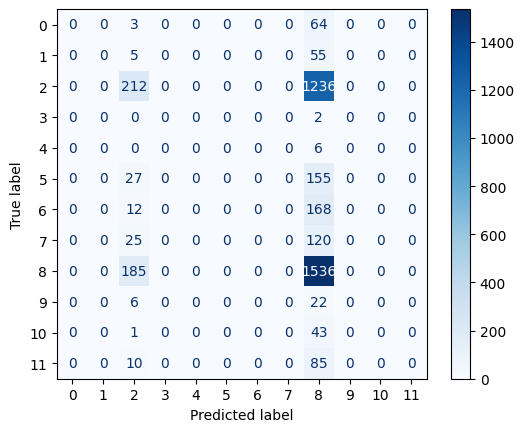

In [70]:
accuracy = accuracy_score(y_test, predicted_list)
precision = precision_score(y_test, predicted_list, average='micro')
recall = recall_score(y_test, predicted_list, average='micro')
f1 = f1_score(y_test, predicted_list, average='micro')

accuracy_m = accuracy_score(y_test, predicted_list)
precision_m = precision_score(y_test, predicted_list, average='macro')
recall_m = recall_score(y_test, predicted_list, average='macro')
f1_m = f1_score(y_test, predicted_list, average='macro')

ConfusionMatrixDisplay.from_predictions(y_test,
                                        predicted_list,
                                        cmap=plt.cm.Blues)

print(f'accuracy micro: {accuracy}')
print(f'precision micro: {precision}')
print(f'recall micro: {recall}')
print(f'f1 micro: {f1}\n\n')


print(f'accuracy macro: {accuracy_m}')
print(f'precision macro: {precision_m}')
print(f'recall macro: {recall_m}')
print(f'f1 macro: {f1_m}')

plt.plot()

### Test 5 epochs model

In [87]:
# Now I can load the model using PyTorch
model = SlowFusionNetVLAD(dropout=0.4)
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # check for GPU availability
model.to(device)

SlowFusionNetVLAD(
  (encoder_2d): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(

In [88]:
test_loss, accuracy,predicted_list=test(model, test_loader, loss_funct, batch_idx=0)

epoch,▁
validation/accuracy,▁
validation/loss,▁
epoch,0
validation/accuracy,0.364
validation/loss,0.23625


In [90]:
predicted_list=[i.cpu().item() for i in predicted_list]

accuracy micro: 0.3640020110608346
precision micro: 0.3640020110608346
recall micro: 0.3640020110608346
f1 micro: 0.36400201106083463


accuracy macro: 0.3640020110608346
precision macro: 0.030333500921736214
recall macro: 0.08333333333333333
f1 macro: 0.044477208502273


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[]

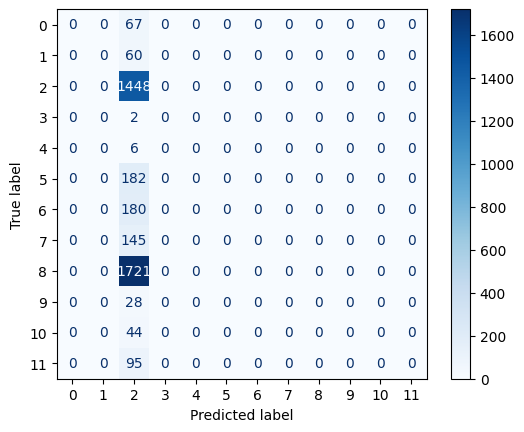

In [91]:
accuracy = accuracy_score(y_test, predicted_list)
precision = precision_score(y_test, predicted_list, average='micro')
recall = recall_score(y_test, predicted_list, average='micro')
f1 = f1_score(y_test, predicted_list, average='micro')

accuracy_m = accuracy_score(y_test, predicted_list)
precision_m = precision_score(y_test, predicted_list, average='macro')
recall_m = recall_score(y_test, predicted_list, average='macro')
f1_m = f1_score(y_test, predicted_list, average='macro')

ConfusionMatrixDisplay.from_predictions(y_test,
                                        predicted_list,
                                        cmap=plt.cm.Blues)

print(f'accuracy micro: {accuracy}')
print(f'precision micro: {precision}')
print(f'recall micro: {recall}')
print(f'f1 micro: {f1}\n\n')


print(f'accuracy macro: {accuracy_m}')
print(f'precision macro: {precision_m}')
print(f'recall macro: {recall_m}')
print(f'f1 macro: {f1_m}')

plt.plot()